### Bibliotecas

In [183]:
import os
import pandas as pd
import re
import geopandas as gpd
from pyproj import CRS
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import matplotlib.patches as mpatches
from geopy.distance import great_circle

### Parâmetros

In [184]:
# Diretório raiz informado
diretorio_raiz = '/Volumes/MiniArmstro/Resultados' 

caminho_status = os.path.join(diretorio_raiz, 'status_pacotes.csv')

# Subprefeituras
subprefeituras = [
    'CASA VERDE-CACHOEIRINHA', 'LAPA', 'SE', 'SANTANA-TUCURUVI',
    'PINHEIROS', 'VILA MARIA-VILA GUILHERME', 'MOOCA',
    'SAO MIGUEL', 'ARICANDUVA-FORMOSA-CARRAO', 'SANTO AMARO'
]

subprefeituras_shp = '/Users/marcelofernandes/Library/CloudStorage/GoogleDrive-marcelo.fernandes@alumni.usp.br/.shortcut-targets-by-id/1M--OnzbTYagrNv5Ss9fjWlBxCMmasz-Y/10_Mestrado_2021_Marcelo Fernandes/8_Dados/SIRGAS_SHP_subprefeitura/SIRGAS_SHP_subprefeitura_polygon.shp'
zonas_shp_OD_2023 = '/Users/marcelofernandes/Library/CloudStorage/GoogleDrive-marcelo.fernandes@alumni.usp.br/.shortcut-targets-by-id/1M--OnzbTYagrNv5Ss9fjWlBxCMmasz-Y/10_Mestrado_2021_Marcelo Fernandes/8_Dados/PESQUISA_ORIGEM_E_DESTINO_2023_anexos/002_Site Metro Mapas/Shape/Zonas_2023.shp'

verbose = True

# Determinar os pixels acima do threshold
threshold = 70  # Valor informado em milímetros, mas convertido para metros, em função do raster. Valor obtido a partir da IC do Rodrigo.
threshold_max = 300 # Valor obtido a partir do paper da Pregnolato. Novamente, valor informado em milímetros, mas convertido para metros.

# Considerando que a primeira linha contém os cabeçalhos e as zonas começam de 1
arquivo_matrizOD = '/Users/marcelofernandes/Library/CloudStorage/GoogleDrive-marcelo.fernandes@alumni.usp.br/.shortcut-targets-by-id/1M--OnzbTYagrNv5Ss9fjWlBxCMmasz-Y/10_Mestrado_2021_Marcelo Fernandes/8_Dados/PESQUISA_ORIGEM_E_DESTINO_2023_anexos/Tabelas_Site_OD2023_120225.xlsx'
matriz_od_25 = pd.read_excel(arquivo_matrizOD, header=7, sheet_name='tab25', index_col=0)
# Exibir as primeiras linhas do DataFrame para verificação
#print(matriz_od_25.head())

blue = "\033[34m"
reset = "\033[0m"

### Listando pacotes

In [185]:
# Se o arquivo já existir, carregue-o
if os.path.exists(caminho_status):
    print("Arquivo de status encontrado. Carregando...")
    df_status_pacotes = pd.read_csv(caminho_status, index_col=0)

else:
    print("Arquivo de status não encontrado. Criando novo...")

    # Encontrar subdiretórios que seguem o padrão "Pacote_XX"
    pacotes = []
    for item in os.listdir(diretorio_raiz):
        caminho_completo = os.path.join(diretorio_raiz, item)
        if os.path.isdir(caminho_completo) and re.match(r'^Pacote_\d{2}$', item):
            pacotes.append(item)

    # Criar o DataFrame com zeros
    df_status_pacotes = pd.DataFrame(0, index=sorted(pacotes), columns=subprefeituras)

    # Salvar para uso futuro
    df_status_pacotes.to_csv(caminho_status)
    print(f"Arquivo de status criado: {caminho_status}")

# Selecionar a sub-prefeitura a ser processada
subprefeitura = subprefeituras[1]
print(f"Sub-prefeitura selecionada: {subprefeitura}")


Arquivo de status não encontrado. Criando novo...
Arquivo de status criado: /Volumes/MiniArmstro/Resultados/status_pacotes.csv
Sub-prefeitura selecionada: LAPA


### Carregando os pontos OD

Bounding boxes geradas com sucesso!


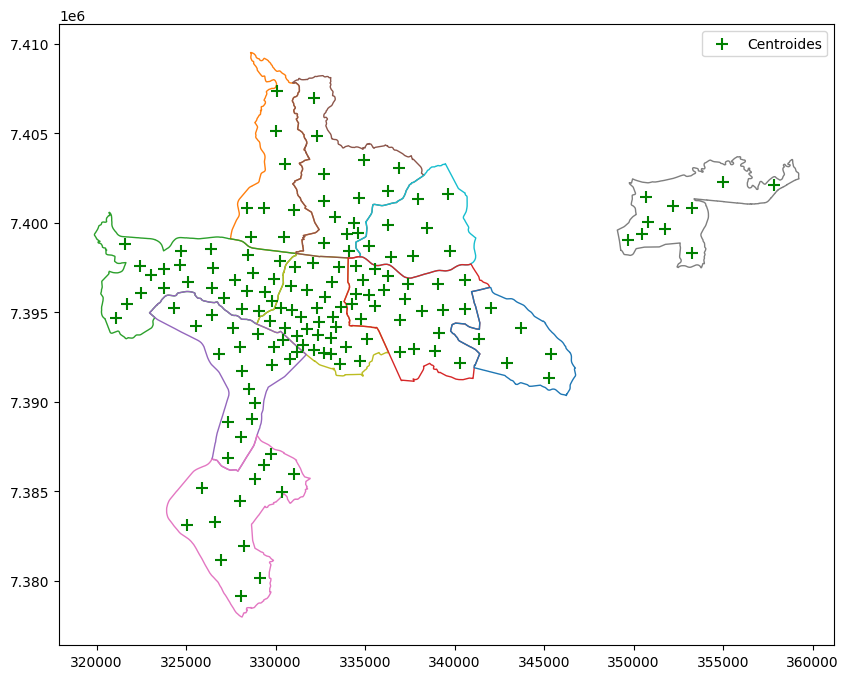

In [186]:
# Carregar o arquivo CSV com as subprefeituras selecionadas
df_subprefeituras = pd.read_csv("resultados_ordenados_alagamentos.csv")

# Selecionar as 10 subprefeituras com maior índice de alagamento
df_sp_lista = df_subprefeituras.sort_values(by="Média", ascending=False).head(10)
#TODO Explicar bem esse critério dentro do capítulo de método

# Carregar o shapefile das subprefeituras
gdf = gpd.read_file(subprefeituras_shp)

# Filtrar o GeoDataFrame para manter apenas as subprefeituras da lista
gdf_sp_filtrado = gdf[gdf["sp_nome"].isin(df_sp_lista["sp_nome"])]

print("Bounding boxes geradas com sucesso!")

# Define the UTM Zone 23S coordinate system
utm_crs = CRS("EPSG:31983")  # UTM Zone 23S, southern hemisphere

# Atribuição do esquema de projeção
gdf_sp_filtrado = gdf_sp_filtrado.set_crs(utm_crs)

gdf_zonas_OD_2023 = gpd.read_file(zonas_shp_OD_2023)

# Atribuição do esquema de projeção
gdf_zonas_OD_2023_utm = gdf_zonas_OD_2023.to_crs(utm_crs)

# Filtrando para o munícipio de São Paulo
gdf_zonas_OD_SP_2023_utm = gdf_zonas_OD_2023_utm[gdf_zonas_OD_2023_utm['NomeMunici'] == 'São Paulo'].copy()

# Obtendo os centroides
gdf_zonas_OD_SP_2023_utm["centroid"] = gdf_zonas_OD_SP_2023_utm["geometry"].centroid

# Garantir que ambos os GeoDataFrames têm o mesmo CRS
gdf_zonas_OD_SP_2023_utm = gdf_zonas_OD_SP_2023_utm.to_crs(gdf_sp_filtrado.crs)

# Filtrar apenas os centroides que estão dentro das subprefeituras selecionadas
centroids = gdf_zonas_OD_SP_2023_utm['centroid']
centroids_filtrados = centroids[centroids.within(gdf_sp_filtrado.union_all())]

# Criar a figura e os eixos
fig, ax = plt.subplots(figsize=(10, 10))

# Plotar as subprefeituras
gdf_sp_filtrado.plot(ax=ax, column='sp_nome', facecolor='none', linewidth=1)

# Extraindo coordenadas dos centroides filtrados
x = centroids_filtrados.x
y = centroids_filtrados.y

# Plotar os centroides filtrados como estrelas (*)
ax.scatter(x, y, color='green', marker='+', s=70, label="Centroides")

# Adicionar legenda
ax.legend()

# Exibir o mapa
plt.show()

CRS atual do edges_baseline: epsg:4326
CRS do edges_baseline_reprojected: EPSG:31983
Grafo obtido com sucesso!
Sub-prefeitura selecionada:  LAPA


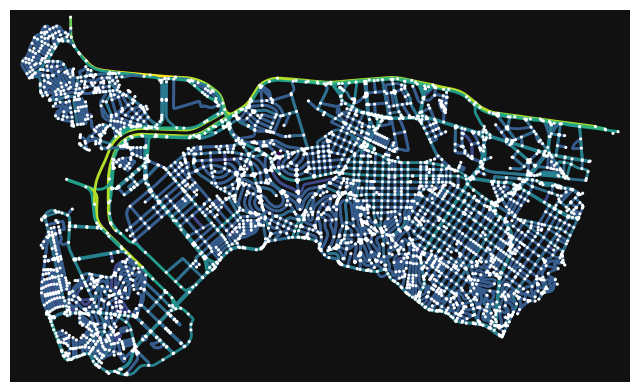

In [187]:
# Dados da subprefeitura
indice_sp = gdf_sp_filtrado[gdf_sp_filtrado['sp_nome'] == subprefeitura].index[0]
nome_sp = subprefeitura

# Verifica e define o CRS
if gdf_sp_filtrado.crs is None:
    gdf_sp_filtrado.set_crs(epsg=4326, inplace=True)  # Define como WGS 84 (latitude/longitude)

# Extrai a geometria
poligono = gdf_sp_filtrado.iloc[indice_sp].geometry

# Certifique-se de que o polígono está em EPSG:4326 (necessário para OSMNX)
if gdf_sp_filtrado.crs.to_epsg() != 4326:
    poligono = gdf_sp_filtrado.to_crs(epsg=4326).loc[indice_sp].geometry

# Obtém o grafo
G_baseline = ox.graph_from_polygon(poligono, network_type="drive")
G_baseline = ox.routing.add_edge_speeds(G_baseline, fallback=50)  # Adiciona a velocidade dos eixos (km/h) ao grafo como o atributo do eixo speed_kph

node_baseline, edges_baseline = ox.graph_to_gdfs(G_baseline)

# Verificar o CRS atual
print("CRS atual do edges_baseline:", edges_baseline.crs)

# Reprojetar para EPSG:31983
edges_baseline_reprojected = edges_baseline.to_crs(epsg=31983)

# Verificar se a reprojeção foi bem-sucedida
print("CRS do edges_baseline_reprojected:", edges_baseline_reprojected.crs)

if verbose:
    print("Grafo obtido com sucesso!")
    print('Sub-prefeitura selecionada: ',nome_sp)
    # Obtendo os comprimentos das arestas
    velocidades = [data['speed_kph'] for _, _, data in G_baseline.edges(data=True)]

    # Normalizando para um mapa de cores
    norm = mcolors.Normalize(vmin=min(velocidades), vmax=max(velocidades))
    cmap = cm.viridis  # Escolha um mapa de cores

    # Definir cores baseadas na velocidade
    edge_colors = [cmap(norm(l)) for l in velocidades]

    # Plotando com cores personalizadas
    fig, ax = ox.plot_graph(
        G_baseline, 
        edge_color=edge_colors, 
        node_size=5, 
        edge_linewidth=2
    )


### Aproximar os pontos OD aos nós da rede

Carregando dados...
Processando subprefeitura: LAPA


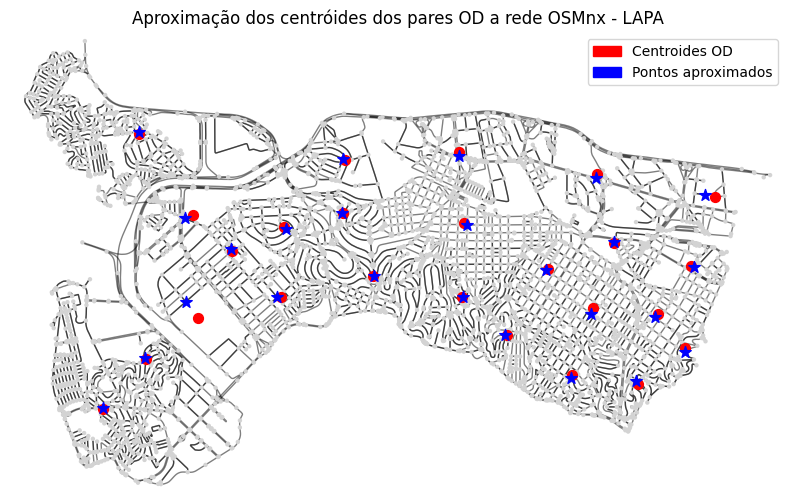

Processamento concluído!


In [188]:
# Definição do CRS UTM para São Paulo
utm_crs = CRS("EPSG:32723")  # UTM Zone 23S

# Ler os dados
print("Carregando dados...")
gdf_OD = gpd.read_file(zonas_shp_OD_2023).to_crs(utm_crs)
gdf_OD_SP = gdf_OD[gdf_OD['NomeMunici'] == 'São Paulo'].copy()
gdf_sp_filtrado = gdf_sp_filtrado.to_crs(utm_crs)

# Iterar sobre cada subprefeitura (aqui, limitado à primeira para teste)
resultados = {}
for idx, subprefeitura in gdf_sp_filtrado.iloc[1:2].iterrows():
    nome_subprefeitura = subprefeitura["sp_nome"]
    print(f"Processando subprefeitura: {nome_subprefeitura}")
    
    # Criar GeoDataFrame da subprefeitura (em UTM)
    gdf_subpref_utm = gpd.GeoDataFrame(geometry=[subprefeitura["geometry"]], crs=utm_crs)
    
    # Converter para EPSG:4326 para extrair a rede com OSMnx (se necessário)
    if gdf_subpref_utm.crs.to_epsg() != 4326:
        gdf_subpref_4326 = gdf_subpref_utm.to_crs(epsg=4326)
        poligono = gdf_subpref_4326.iloc[0].geometry
    else:
        poligono = subprefeitura["geometry"]

    # Extrair o grafo para a área do polígono e adicionar velocidades (km/h)
    G_baseline = ox.graph_from_polygon(poligono, network_type="drive")
    G_baseline = ox.routing.add_edge_speeds(G_baseline, fallback=50)
    
    # Projetar o grafo para UTM
    G_baseline_utm = ox.project_graph(G_baseline, to_crs=utm_crs)
    
    # Cria um GeoDataFrame com os centróides dos pontos OD
    gdf_OD_centroids = gdf_OD_SP.copy()
    gdf_OD_centroids["centroide"] = gdf_OD_centroids.geometry.centroid
    # Importante: definir o CRS como o utm_crs, pois os dados já foram convertidos
    gdf_OD_centroids = gpd.GeoDataFrame(gdf_OD_centroids, geometry="centroide", crs=utm_crs)
    
    # Define o polígono da subprefeitura para a junção espacial
    subpref_polygon = gdf_subpref_utm

    # Realiza a junção espacial para identificar os centróides dentro da subprefeitura
    gdf_centroids_in_subpref = gdf_OD_centroids.sjoin(subpref_polygon, how="inner", predicate="within")
    
    # Agora, usamos os centróides que caíram dentro da subprefeitura
    centroides_df = gdf_centroids_in_subpref.copy()
    
    # Aproximar os pontos à rede: encontrar o nó mais próximo para cada centroide
    coluna_nome = f"nearest_node_{nome_subprefeitura.replace(' ', '_')}"
    centroides_df[coluna_nome] = centroides_df.geometry.apply(
        lambda point: ox.distance.nearest_nodes(G_baseline_utm, point.x, point.y)
    )
    
    # Obter coordenadas dos nós aproximados
    centroides_df["node_x"] = centroides_df[coluna_nome].map(lambda node: G_baseline_utm.nodes[node]["x"])
    centroides_df["node_y"] = centroides_df[coluna_nome].map(lambda node: G_baseline_utm.nodes[node]["y"])
    
    # Criar GeoDataFrame com os nós aproximados
    gdf_nos_aproximados = gpd.GeoDataFrame(
        centroides_df,
        geometry=gpd.points_from_xy(centroides_df["node_x"], centroides_df["node_y"]),
        crs=utm_crs
    )
    
    # Armazenar resultado
    resultados[nome_subprefeitura] = gdf_nos_aproximados
    
    # Plotar: grafo, centróides originais e nós aproximados
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Plota o grafo OSMnx no ax já criado
    fig, ax = ox.plot_graph(
        G_baseline_utm, ax=ax, node_color='lightgray', node_size=10,
        edge_color='black', edge_alpha=0.5, show=False, close=False
    )

    # Plota os centróides dos pontos OD (apenas os que estão dentro da subprefeitura)
    centroides_df.plot(ax=ax, marker='o', color='red', markersize=50, label='Centroides OD', zorder=3)

    # Plota os pontos aproximados (nós da rede)
    gdf_nos_aproximados.plot(
        ax=ax, marker='*', color='blue', markersize=75,
        label='Pontos aproximados', zorder=4
    )
    
    plt.title(f'Aproximação dos centróides dos pares OD a rede OSMnx - {nome_subprefeitura}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    
    # Cria legendas
    legenda_centroides = mpatches.Patch(color='red', label='Centroides OD')
    legenda_aprox = mpatches.Patch(color='blue', label='Pontos aproximados')
    plt.legend(handles=[legenda_centroides, legenda_aprox])
    
    plt.show()

# Combinar todos os GeoDataFrames em um único
resultado_final = gpd.GeoDataFrame(pd.concat(resultados.values(), ignore_index=True))

print("Processamento concluído!")


### Funções de apoio

In [189]:
def filtrar_centroides_por_subprefeitura(gdf_zonas, gdf_subprefeituras, subprefeitura, utm_crs):
    """
    Filtra os centroides das zonas OD que estão dentro de uma determinada subprefeitura.

    Parâmetros:
    - gdf_zonas: GeoDataFrame das zonas OD
    - gdf_subprefeituras: GeoDataFrame das subprefeituras, contendo a coluna 'sp_nome'
    - subprefeitura: Nome da subprefeitura a ser filtrada
    - utm_crs: Sistema de referência de coordenadas UTM a ser usado

    Retorna:
    - Um GeoDataFrame contendo os centroides filtrados
    """

    # Atribuir o esquema de projeção
    gdf_zonas_utm = gdf_zonas.to_crs(utm_crs)

    # Filtrar para o município de São Paulo
    gdf_zonas_sp = gdf_zonas_utm[gdf_zonas_utm['NomeMunici'] == 'São Paulo'].copy()

    # Criar a coluna de centroides
    gdf_zonas_sp["centroid"] = gdf_zonas_sp["geometry"].centroid

    # Garantir que ambos os GeoDataFrames têm o mesmo CRS
    gdf_zonas_sp = gdf_zonas_sp.to_crs(gdf_subprefeituras.crs)

    # Criar um GeoDataFrame com os centroides
    centroids_gdf = gpd.GeoDataFrame(gdf_zonas_sp[['centroid']], geometry='centroid', crs=gdf_subprefeituras.crs)

    # Realizar o spatial join para adicionar a subprefeitura a cada centróide
    centroids_filtrados = gpd.sjoin(centroids_gdf, gdf_subprefeituras[['geometry', 'sp_nome']], how='inner', predicate='within')

    # Filtrar para a subprefeitura específica
    centroids_filtrados = centroids_filtrados[centroids_filtrados['sp_nome'] == subprefeitura]

    return centroids_filtrados

def adjust_speed_batch(row, raster_data, transform, threshold, threshold_max, speed_column):
    """
    Ajusta a velocidade de um segmento com base na profundidade do alagamento extraída de um raster.

    Parâmetros:
        row (GeoSeries): Linha atual do GeoDataFrame contendo informações de velocidade e geometria.
        raster_data (numpy.ndarray): Dados do raster contendo profundidade de alagamento.
        transform (Affine): Transformação do raster para coordenadas espaciais.
        threshold (float): Profundidade mínima para ajustar a velocidade.
        threshold_max (float): Profundidade máxima que torna a via intransitável.
        speed_column (str): Nome da coluna de referência para a velocidade original.
    
    Retorno:
        float: Velocidade ajustada para o segmento.
    """

    # Encontrar a coordenada do centro do segmento
    centroid = row.geometry.centroid

    # Transformar as coordenadas do centroide em índices do raster
    try:
        col_idx, row_idx = ~transform * (centroid.x, centroid.y) # Observe a ordem inversa
        row_idx, col_idx = int(row_idx), int(col_idx)
    except Exception:
        # Caso algo dê errado na transformação, manter a velocidade original
        #print('Mantive a velocidade que veio!')
        return row[speed_column]

    # Verificar se os índices estão dentro dos limites do raster
    if not (0 <= row_idx < raster_data.shape[0] and 0 <= col_idx < raster_data.shape[1]):
        print(row_idx, raster_data.shape[0], col_idx, raster_data.shape[1])
        return row[speed_column]
    
    # Extração do valor de profundidade do raster
    flood_depth = 1000*raster_data[row_idx, col_idx] # Valor extraído do raster em metros
    #print(flood_depth)

    # Ajustar a velocidade com base na profundidade
    if flood_depth > threshold_max:
        # Caso a altura exceda o limiar máximo, torna-se instransitável
        return 0
    elif flood_depth > threshold:
        # Aplicar a fórmula de ajuste da velocidade
        adjusted_speed = 0.0009 * (flood_depth ** 2) - 0.5529 * flood_depth + 86.9448
        #print('Pregnolato!')
        return min(adjusted_speed, row[speed_column])  # Garantir que não ultrapasse a velocidade original
        
    # Caso contrário, manter a velocidade original
    return row[speed_column]

def listar_atributos_arestas(G):
    atributos = set()
    for _, _, dados in G.edges(data=True):
        atributos.update(dados.keys())
    return atributos

# 1. Função para obter o número de viagens da matriz OD
def get_number_of_trips(node1, node2, referencia, od_matrix):
    zone1 = gdf_nos_aproximados.loc[gdf_nos_aproximados[referencia] == node1, 'NumeroZona'].values[0]
    zone2 = gdf_nos_aproximados.loc[gdf_nos_aproximados[referencia] == node2, 'NumeroZona'].values[0]
    #print(f'O número de viagens entre {zone1} e {zone2} é {od_matrix.loc[zone1, zone2]}')
    return od_matrix.loc[zone1, zone2]

def tempo_medio_viagem(arquivo):

    # Filtrar os valores finitos para tempo com peso e num_viagens
    finite_mask_baseline = np.isfinite(arquivo['Tempo ponderado (min)'])
    finite_tempos_e_viagens_baseline = arquivo[finite_mask_baseline]

    # Calcular o número total de viagens sem valores infinitos
    total_trips_weighted = finite_tempos_e_viagens_baseline['Num_viagens'].sum()

    # Calcular o tempo total sem peso ignorando valores infinitos
    total_time_weighted = finite_tempos_e_viagens_baseline['Tempo ponderado (min)'].sum()

    # Calcular o tempo médio de viagem ponderado
    mean_time_weighted = total_time_weighted / total_trips_weighted

    # Exibir os resultados
    #print(f"Tempo médio de viagem com chuva e ponderado: {mean_time_weighted:.2f} minutos")

    return mean_time_weighted

def verificar_pendencias_lote(diretorio_raiz, pacote_inicio, pacote_fim, subprefeitura=None):
    """
    Verifica pendências de processamento para um intervalo de pacotes, 
    opcionalmente focando em uma subprefeitura específica.

    Parâmetros:
    - diretorio_raiz: caminho onde está o status_pacotes.csv
    - pacote_inicio: nome do primeiro pacote (ex: 'Pacote_01')
    - pacote_fim: nome do último pacote (ex: 'Pacote_05')
    - subprefeitura: (opcional) nome da subprefeitura para filtrar pendências

    Retorna:
    - Um DataFrame com os pacotes e subprefeituras pendentes.
    """
    caminho_status = os.path.join(diretorio_raiz, 'status_pacotes.csv')

    subprefeituras = [
        'CASA VERDE-CACHOEIRINHA', 'LAPA', 'SE', 'SANTANA-TUCURUVI',
        'PINHEIROS', 'VILA MARIA-VILA GUILHERME', 'MOOCA',
        'SAO MIGUEL', 'ARICANDUVA-FORMOSA-CARRAO', 'SANTO AMARO'
    ]

    if not os.path.exists(caminho_status):
        raise FileNotFoundError(f"Arquivo de controle não encontrado em: {caminho_status}")

    # Carrega o DataFrame e garante ordenação
    df_status = pd.read_csv(caminho_status, index_col=0).sort_index()

    if pacote_inicio not in df_status.index or pacote_fim not in df_status.index:
        raise ValueError("Pacote inicial ou final não encontrado no arquivo de status.")

    # Filtrar intervalo
    df_lote = df_status.loc[pacote_inicio:pacote_fim]

    # Verificação por subprefeitura específica (corrigida)
    if subprefeitura is not None:
        subprefeitura = str(subprefeitura).strip()

        if subprefeitura and subprefeitura in df_status.columns:
            pendentes = df_lote[df_lote[subprefeitura] == 0][[subprefeitura]]
            print(f"Pendências para a subprefeitura: {subprefeitura}")
        else:
            raise ValueError(f"Subprefeitura '{subprefeitura}' não encontrada.")
    
    else:
        # Verifica múltiplas colunas
        pendentes = df_lote[df_lote[subprefeituras].eq(0)].dropna(how='all', subset=subprefeituras)
        print("Pendências para todas as subprefeituras:")

    print(pendentes)
    return pendentes

import logging

def configurar_logging(caminho_log='processamento.log', nivel=logging.INFO):
    """
    Configura logging para exibir mensagens no console e salvar em arquivo.
    
    Parâmetros:
    - caminho_log: caminho do arquivo de log
    - nivel: nível mínimo de log (default: logging.INFO)
    """
    logger = logging.getLogger()
    logger.setLevel(nivel)

    # Remover handlers antigos
    if logger.hasHandlers():
        logger.handlers.clear()

    # Criar formato para log
    formato_arquivo = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
    formato_console = logging.Formatter('%(message)s')

    # Handler para arquivo
    file_handler = logging.FileHandler(caminho_log)
    file_handler.setFormatter(formato_arquivo)

    # Handler para console
    console_handler = logging.StreamHandler()
    console_handler.setFormatter(formato_console)

    # Adicionar handlers ao logger
    logger.addHandler(file_handler)
    logger.addHandler(console_handler)

import os
import pandas as pd
from tqdm import tqdm
import logging


### Função principal

In [190]:

def processar_pendencias(
    diretorio_raiz,
    pacote_inicio,
    pacote_fim,
    edges_baseline_reprojected,
    node_baseline,
    subprefeitura=None,
    threshold=70,
    threshold_max=300,
    status_filename='status_pacotes.csv',
    verbose=True
):
    """
    Processa os pacotes e subprefeituras com status pendente (valor 0) dentro de um intervalo.

    Parâmetros:
    - diretorio_raiz: pasta onde estão os pacotes e o arquivo de status
    - pacote_inicio: string, exemplo 'Pacote_01'
    - pacote_fim: string, exemplo 'Pacote_05'
    - subprefeitura: (opcional) subprefeitura única a ser processada
    - status_filename: nome do arquivo de status (default: status_pacotes.csv)
    """
    # Configura logging (arquivo + console)
    log_path = os.path.join(diretorio_raiz, 'processamento.log')
    configurar_logging(caminho_log=log_path)
    logging.info("🚀 Iniciando processamento de pendências")

    # Caminho do arquivo de status
    caminho_status = os.path.join(diretorio_raiz, status_filename)

    # Obter pendências
    pendencias = verificar_pendencias_lote(
        diretorio_raiz,
        pacote_inicio,
        pacote_fim,
        subprefeitura=subprefeitura
    )

    if pendencias.empty:
        print(f"🛑 Encerrando: não há pendências para processar entre os {blue}{pacote_inicio}{reset} e {blue}{pacote_fim}{reset}.")
        return  

    # Carregar status atual para edição
    df_status = pd.read_csv(caminho_status, index_col=0)

    # Total de tarefas pendentes
    total = (pendencias == 0).sum().sum()

    # Inicializar resultado acumulado
    df_resultados_resiliencia = pd.DataFrame()

    # Loop com barra de progresso
    with tqdm(total=total, desc="Processando pendências") as pbar:
        for pacote in pendencias.index:
            for sp in pendencias.columns:
                if pendencias.loc[pacote, sp] == 0:
                    try:
                        logging.info(f"\n🔄 Iniciando: {pacote} | {sp}")
                        print(f"🔄 Processando {blue}{pacote}{reset} | {blue}{sp}{reset}")

                        arquivos, caminho = listar_arquivos_tif_ordenados(diretorio_raiz, pacote, subprefeitura)
                        if verbose:
                            print('\nListagem dos arquivos a serem processados:')
                            for nome in arquivos:
                                print(f'{pacote}, {subprefeitura}, {nome}')
                            print(f"\nCaminho: {caminho}")
                            print(f'\n1. Arquivos referentes ao pacote {pacote} encontrados ✅\n')
                        
                        # 👇 Clonando o baseline antes de qualquer modificação
                        edges_baseline_pacote = edges_baseline_reprojected.copy(deep=True)

                        if verbose:
                            print('Inspecionando as colunas existentes ANTES do ajuste de velocidade:')
                            for coluna in edges_baseline_pacote.columns:
                                print(coluna)

                        edges_baseline_pacote = ajustar_velocidades_com_rasters(
                                                        arquivos,
                                                        caminho,
                                                        edges_baseline_pacote,
                                                        threshold=threshold,
                                                        threshold_max=threshold_max,
                                                        verbose=False
                                                        )
                        if verbose:
                            print(f'\n{blue}Inspecionando as colunas que foram adicionadas no ajuste de velocidade.{reset}')
                            print('Verificar a adição das colunas que representam as horas de simulação:')
                            for coluna in edges_baseline_pacote.columns:
                                print(coluna)
                            print(f'\n2. Transferência de velocidade dos rasters efetuada ✅\n')

                        edges_simulados, detalhes_arquivo_df = processar_lote_tempos_de_viagem(
                                                        gdf=edges_baseline_pacote,
                                                        arquivos_ordenados=arquivos,
                                                        coluna_baseline='speed_kph',
                                                        verbose=True
                                                        )
                        
                        if verbose:
                            print('\nInspecionando as colunas após inclusão do tempo de viagem.')
                            print('Verificar a adição das colunas que começam com tt - travel time:')
                            for coluna in edges_baseline_pacote.columns:
                                print(coluna)
                            print(f'\n3. Tempos de viagem adicionados a rede ✅\n')
                        

                        G_dinamico = ox.graph_from_gdfs(node_baseline, edges_simulados)
                        
                        if verbose:
                            ox.plot_graph(G_dinamico)
                            print('Verificação se os atributos do GDF foram transferidos para o grafo:')
                            u, v, k = list(G_dinamico.edges(keys=True))[0]
                            for item in G_dinamico[u][v][k].keys():
                                print(item)
                            
                            if 'tt_speed_kph' not in G_dinamico[u][v][k]:
                                print("❌ 'tt_speed_kph' não está nas arestas como atributo!")

                            print(f'\n4. Grafo de viagem reconstruido ✅\n')
                            
                        atributos_tt_ord = listar_atributos_tt_ordenados(
                                                        G_dinamico,
                                                        func_extrair_numero=extrair_numero,
                                                        verbose=True
                                                        )

                        if verbose:
                            print(f'\n5. Atributos de tempo de viagem listados ✅\n')
                        
                        coluna_referencia = 'nearest_node_' + subprefeitura
                        
                        df_resultados_tmp = avaliar_resiliencia_tempos_de_viagem(
                            atributos_tt_ord=atributos_tt_ord,
                            gdf_nos_aproximados=gdf_nos_aproximados,
                            G_dinamico=G_dinamico,
                            coluna_desejada=coluna_referencia,
                            verbose=True
                            )
                        
                        # Adiciona as colunas antes de acumular
                        df_resultados_tmp["Pacote"] = pacote
                        df_resultados_tmp["Subprefeitura"] = subprefeitura

                        # Reorganiza as colunas para colocar "Pacote" no início
                        cols = ["Pacote", "Subprefeitura"] + [col for col in df_resultados_tmp.columns if col != "Pacote"]
                        df_resultados_tmp = df_resultados_tmp[cols]

                        df_resultados_resiliencia = pd.concat([df_resultados_resiliencia, df_resultados_tmp], ignore_index=True)

                        if verbose:
                            print(f'\n6. Resultados de resiliência calculados ✅\n')

                        # Marca como concluído
                        df_status.loc[pacote, sp] = 1
                        logging.info(f"✔️ Concluído: {pacote} | {sp}")
                    
                    except Exception as e:
                        logging.error(f"❌ Erro ao processar {pacote} | {sp}: {e}")
                    
                    pbar.update(1)

    # Salvar status atualizado
    df_status.to_csv(caminho_status)
    logging.info("✅ Processamento finalizado e status atualizado.")
    return df_resultados_resiliencia


In [191]:
def processar_lote_tempos_de_viagem(gdf, arquivos_ordenados, coluna_baseline='speed_kph', verbose=False):
    """
    Processa um lote de arquivos de referência para calcular tempo de viagem e retorna
    o GeoDataFrame modificado e um DataFrame com detalhes das execuções.

    Parâmetros:
    - gdf: GeoDataFrame base com as colunas de velocidade e length
    - arquivos_ordenados: lista de strings com os nomes dos arquivos de referência
    - coluna_baseline: nome da coluna que será considerada como baseline
    - verbose: se True, imprime logs

    Retorna:
    - gdf: GeoDataFrame com novas colunas de tempo de viagem
    - detalhes_df: DataFrame com os detalhes do processamento por referência
    """
    import re
    import pandas as pd

    data_batch = []

    for i, coluna in enumerate(arquivos_ordenados, start=1):
        if verbose:
            print(f"⏳ Processando: {coluna.replace('.tif', '')}")
        gdf = add_edge_travel_times_gdf2(gdf, coluna.replace('.tif', ''))
        data_batch.append({
            'index': i,
            'Referência': coluna.replace('.tif', ''),
        })

    # Adiciona o baseline
    if verbose:
        print(f"⚙️ Adicionando baseline: {coluna_baseline}")
    gdf = add_edge_travel_times_gdf2(gdf, coluna_baseline)
    data_batch.append({
        'index': len(data_batch) + 1,
        'Referência': coluna_baseline,
    })

    detalhes_df = pd.DataFrame(data_batch)

    # Criar coluna "Max" e identificar os arquivos max_
    #detalhes_df["Max"] = 0
    #linha_max = detalhes_df[detalhes_df["Referência"].str.contains("max_", na=False)]

    #if not linha_max.empty:
    #    match = re.search(r"max_(\d+)", linha_max["Referência"].values[0])
    #    if match:
    #        numero_max = match.group(1)
    #    detalhes_df.loc[
    #        detalhes_df["Referência"].str.contains(f"h_{numero_max}", na=False), "Max"
    #    ] = 1

    # Remover linha max_ e resetar índices
    #detalhes_df = detalhes_df[~detalhes_df["Referência"].str.contains("max_", na=False)]
    #detalhes_df.reset_index(drop=True, inplace=True)

    return gdf, detalhes_df

import os
import re

def listar_arquivos_tif_ordenados(output_folder, pacote_num, nome_sp):
    """
    Lista arquivos .tif ordenados numericamente a partir de um diretório específico de subprefeitura,
    excluindo arquivos que contenham 'max' no nome.
    
    Parâmetros:
    - output_folder: caminho base onde estão os pacotes
    - pacote_num: nome do pacote, ex: 'Pacote_01'
    - nome_sp: nome da subprefeitura, ex: 'LAPA'
    
    Retorna:
    - Lista de arquivos .tif ordenados (sem arquivos com 'max' no nome)
    - Caminho completo da pasta onde eles estão
    """
    # Caminho onde estão os arquivos TIFF
    clipado_path = os.path.join(output_folder, pacote_num, 'Sub-prefeituras', nome_sp)

    if not os.path.isdir(clipado_path):
        raise FileNotFoundError(f"❌ O diretório {clipado_path} não foi encontrado.")

    # Listar arquivos .tif válidos, excluindo os que contêm 'max'
    arquivos_tif = [
        f for f in os.listdir(clipado_path)
        if f.endswith(".tif") and not f.startswith("._") and 'max' not in f
    ]

    # Função auxiliar para extrair número de nome do arquivo
    def extrair_numero(nome):
        match = re.search(r'(?:h_)(\d+)', nome)
        return int(match.group(1)) if match else float('inf')

    # Ordenar arquivos
    arquivos_ordenados = sorted(arquivos_tif, key=extrair_numero)

    return arquivos_ordenados, clipado_path


import os
import re
import rasterio

def ajustar_velocidades_com_rasters(
    arquivos_ordenados,
    clipado_path,
    edges_baseline_reprojected,
    threshold,
    threshold_max,
    verbose=True
):
    """
    Aplica ajuste de velocidade em edges a partir de rasters TIFFs ordenados.

    Parâmetros:
    - arquivos_ordenados: lista dos arquivos .tif ordenados
    - clipado_path: caminho onde estão os arquivos
    - edges_baseline_reprojected: GeoDataFrame de edges com colunas de velocidade
    - threshold: limite inferior de aplicação de penalidade
    - threshold_max: limite superior de penalidade (para arquivos _max)
    - verbose: se True, imprime informações detalhadas
    """
    total_arquivos = len(arquivos_ordenados)

    for index, filename in enumerate(arquivos_ordenados, start=1):
        if verbose:
            print(f"\n🔄 Processando arquivo {index} de {total_arquivos}: {filename}")

        match = re.search(r'pct(?P<pct>[\d.]+)_h(?:_max)?_(?P<value>\d+)', filename)

        if verbose and not match:
            print(f"⚠️  Regex não bateu com o nome do arquivo: {filename}")

        if match:
            pct = match.group('pct')
            value = match.group('value')
            is_max = '_max' in filename

            column_suffix = f"pct{pct}_h_{value}" + ("_max" if is_max else "")
            column_name = column_suffix

            raster_path = os.path.join(clipado_path, filename)

            with rasterio.open(raster_path) as src:
                raster_data = src.read(1)
                raster_transform = src.transform

            # Aplica função de ajuste de velocidade
            edges_baseline_reprojected[column_name] = edges_baseline_reprojected.apply(
                adjust_speed_batch,
                axis=1,
                args=(raster_data, raster_transform, threshold, threshold_max, 'speed_kph')
            )

            # Estatísticas de impacto
            count_zero = (edges_baseline_reprojected[column_name] == 0).sum()
            count_modified = (
                (edges_baseline_reprojected[column_name] != edges_baseline_reprojected["speed_kph"]) &
                (edges_baseline_reprojected[column_name] != 0)
            ).sum()
            count_unchanged = (edges_baseline_reprojected[column_name] == edges_baseline_reprojected["speed_kph"]).sum()

            if verbose:
                print(f"🔧 Velocidades ajustadas para zero: {count_zero} ou {count_zero/len(edges_baseline_reprojected)*100:.2f}%")
                print(f"🟡 Velocidades modificadas: {count_modified} ou {count_modified/len(edges_baseline_reprojected)*100:.2f}%")
                print(f"🟢 Velocidades inalteradas: {count_unchanged} ou {count_unchanged/len(edges_baseline_reprojected)*100:.2f}%")

    if verbose:
        print("\n✅ Processamento de rasters concluído!\n")

    return edges_baseline_reprojected

def adjust_speed_batch(row, raster_data, transform, threshold, threshold_max, speed_column):
    """
    Ajusta a velocidade de um segmento com base na profundidade do alagamento extraída de um raster.

    Parâmetros:
        row (GeoSeries): Linha atual do GeoDataFrame contendo informações de velocidade e geometria.
        raster_data (numpy.ndarray): Dados do raster contendo profundidade de alagamento.
        transform (Affine): Transformação do raster para coordenadas espaciais.
        threshold (float): Profundidade mínima para ajustar a velocidade.
        threshold_max (float): Profundidade máxima que torna a via intransitável.
        speed_column (str): Nome da coluna de referência para a velocidade original.
    
    Retorno:
        float: Velocidade ajustada para o segmento.
    """

    # Encontrar a coordenada do centro do segmento
    centroid = row.geometry.centroid

    # Transformar as coordenadas do centroide em índices do raster
    try:
        col_idx, row_idx = ~transform * (centroid.x, centroid.y) # Observe a ordem inversa
        row_idx, col_idx = int(row_idx), int(col_idx)
    except Exception:
        # Caso algo dê errado na transformação, manter a velocidade original
        #print('Mantive a velocidade que veio!')
        return row[speed_column]

    # Verificar se os índices estão dentro dos limites do raster
    if not (0 <= row_idx < raster_data.shape[0] and 0 <= col_idx < raster_data.shape[1]):
        print(row_idx, raster_data.shape[0], col_idx, raster_data.shape[1])
        return row[speed_column]
    
    # Extração do valor de profundidade do raster
    flood_depth = 1000*raster_data[row_idx, col_idx] # Valor extraído do raster em metros
    #print(flood_depth)

    # Ajustar a velocidade com base na profundidade
    if flood_depth > threshold_max:
        # Caso a altura exceda o limiar máximo, torna-se instransitável
        return 0
    elif flood_depth > threshold:
        # Aplicar a fórmula de ajuste da velocidade
        adjusted_speed = 0.0009 * (flood_depth ** 2) - 0.5529 * flood_depth + 86.9448
        #print('Pregnolato!')
        return min(adjusted_speed, row[speed_column])  # Garantir que não ultrapasse a velocidade original
        
    # Caso contrário, manter a velocidade original
    return row[speed_column]

def add_edge_travel_times_gdf2(gdf, referencia, verbose=False):
    import re
    import numpy as np

    # Extrair a parte relevante da referência (até a segunda sequência numérica)
    padrao = r'^((?:[^\d]*\d+){3})'
    match = re.match(padrao, referencia)
    ref_clean = match.group(1) if match else referencia
    
    col_speed = ref_clean
    col_tt = f'tt_{ref_clean}'
        
    if verbose:
        print(f'O valor da referência é: {col_tt}')
    
    # Garantir a existência da coluna de velocidade; se não existir, criar com valor 0
    if col_speed not in gdf.columns:
        print(f'Aviso: a coluna "{col_speed}" não existe no GeoDataFrame. Criando-a com valor 0.')
        gdf[col_speed] = 0

    # Garantir que a coluna 'length' exista e preencher valores ausentes com 0
    if 'length' not in gdf.columns:
        print('Aviso: a coluna "length" não existe no GeoDataFrame. Criando-a com valor 0.')
        gdf['length'] = 0
    else:
        gdf['length'] = gdf['length'].fillna(0)

    # Calcular os tempos de viagem:
    # Se a velocidade é 0, atribuir 9999; caso contrário, calcular (length * 3.6) / velocidade.
    gdf[col_tt] = np.where(gdf[col_speed] == 0, 9999, (gdf['length'] * 3.6) / gdf[col_speed])
    
    return gdf

# Atualizações para incorporar o sem_caminho e otimizações de código
import time
import itertools
import pandas as pd


In [192]:

def calcula_caminho_minimo_star2(gdf_OD, referencia_OD, G, referencia, **kwargs):
    """
    Calcula caminhos mínimos entre pares de nós em um grafo OSMnx, considerando apenas vias transitáveis.
    Otimizado para rodar em grande escala.
    """
    if not all('tt_speed_kph' in data for _, _, _, data in G.edges(keys=True, data=True)):
        raise ValueError("❌ Alguma aresta do grafo não contém 'tt_speed_kph'.")
    
    sem_caminho = kwargs.get('sem_caminho_chuva')
    if sem_caminho is None:
        sem_caminho = set()
    elif not isinstance(sem_caminho, set):
        sem_caminho = set(tuple(pair) for pair in sem_caminho)

    #G = pre_processar_grafo_star(G, referencia)  # Pré-processa o grafo
    peso = referencia if any(referencia in d for _, _, d in G.edges(data=True)) else "length"
    #print(f'A referência utilizada é: ',referencia)
    #print(f'A referência OD utilizada é: ',referencia_OD)

    nos_validos = set(G.nodes)  # Evita buscas repetitivas no grafo
    #print(f'Nós validos: ',nos_validos)
    data_batch = []
    tempo_acumulado = 0
    total_viagens = 0
    start_time = time.time()

    # Pré-calcula número de viagens entre pares
    matriz_od = { (n1, n2): get_number_of_trips(n1, n2, referencia_OD, matriz_od_25) 
                  for n1, n2 in itertools.permutations(gdf_OD[referencia_OD], 2) 
                  if (n1, n2) not in sem_caminho and n1 in nos_validos and n2 in nos_validos }
    #print(f'A matriz OD é: ',matriz_od)

    for (node1, node2), num_viagens in matriz_od.items():
        #print('Começando os cálculos dos tempos de viagem')
        if num_viagens == 0:
            continue  # Ignora pares sem viagens registradas
        
        caminho, tempo = caminho_minimo_star(G, node1, node2, peso)
        if caminho is not None:
            tempo_total = tempo * num_viagens
            tempo_acumulado += tempo_total
            total_viagens += num_viagens

            data_batch.append({
                'Referência': referencia,
                'Origem': node1,
                'Destino': node2,
                'Tempo de viagem (s)': tempo,
                'Número de viagens': num_viagens,
                'Tempo total ponderado (s)': tempo_total,
                'Número de nós': len(caminho),
                'Percurso entre nós': list(caminho)
            })
        else:
            print(f'Sem caminho antes: {sem_caminho}')
            sem_caminho.add((node1, node2))
            print(f'Sem caminho depois: {sem_caminho}')

    tempo_medio = (tempo_acumulado / total_viagens) / 60 if total_viagens > 0 else None

    print(f"Tempo de processamento: {(time.time() - start_time) :.2f} s")
    print(f'Viagens calculadas: {len(data_batch)}')
    #print(f'Viagens sem conexão: {blue}{len(sem_caminho)}{reset}')
    #print(f'Tempo médio de viagem ponderado: {blue} {tempo_medio:.2f} min {reset}' if tempo_medio else "Nenhuma viagem processada")

    return pd.DataFrame(data_batch), sem_caminho, tempo_medio

def pre_processar_grafo_star(G, referencia):
    """
    Pré-processa o grafo removendo arestas inválidas e identificando componentes conectados.
    """
    G_filtrado = G.copy()
    
    #print("Número de arestas antes do pré-processamento:", len(G_filtrado.edges()))
   
    #edges_remover = [(u, v, k) for u, v, k, d in G_filtrado.edges(keys=True, data=True) if referencia in d and d[referencia] == 9999]

    #G_filtrado.remove_edges_from(edges_remover)
    
    # Manter apenas a componente fortemente conectada maior
    componentes = list(nx.strongly_connected_components(G_filtrado))
    maior_componente = max(componentes, key=len)
    G_filtrado = G_filtrado.subgraph(maior_componente).copy()
    
    # Plotargrafo
    #fig, ax = plt.subplots(figsize=(10, 10))
    
    # Plota o grafo OSMnx no ax já criado
    #fig, ax = ox.plot_graph(
    #    G_filtrado, ax=ax, node_color='lightgray', node_size=10,
    #    edge_color='black', edge_alpha=0.5, show=False, close=False
    #)
    #print("Número de arestas após pré-processamento:", len(G_filtrado.edges()))

    return G_filtrado

def heuristica_haversine(G, origem, destino):
    """
    Calcula a distância haversine entre dois nós do grafo.
    """
    lat1, lon1 = G.nodes[origem]['y'], G.nodes[origem]['x']
    lat2, lon2 = G.nodes[destino]['y'], G.nodes[destino]['x']
    return great_circle((lat1, lon1), (lat2, lon2)).meters

def caminho_minimo_star(G, origem, destino, peso):
    """
    Calcula o caminho mínimo entre dois nós no grafo pré-processado usando A*.
    """
    if not nx.has_path(G, origem, destino):
        return None, None
    
    try:
        caminho = nx.astar_path(G, source=origem, target=destino, weight=peso, heuristic=lambda u, v: heuristica_haversine(G, u, v))
        distancia = nx.astar_path_length(G, source=origem, target=destino, weight=peso, heuristic=lambda u, v: heuristica_haversine(G, u, v))
        return caminho, distancia
    except nx.NetworkXNoPath:
        return None, None


### Avaliar resiliência

In [193]:
def avaliar_resiliencia_tempos_de_viagem(
    atributos_tt_ord,
    gdf_nos_aproximados,
    G_dinamico,
    coluna_desejada,
    blue='',
    reset='',
    verbose=True
):
    """
    Avalia a resiliência da rede de transporte simulando tempos de viagem com e sem chuva.

    Parâmetros:
    - atributos_tt_ord: lista de colunas de tempo simuladas (com chuva)
    - gdf_nos_aproximados: GeoDataFrame com os pares OD e nós de referência
    - G_dinamico: grafo com os tempos simulados como atributos
    - coluna_desejada: nome da coluna base de tempo de viagem (ex: nearest_node_LAPA)
    - blue/reset: strings para formatação de cor no terminal
    - verbose: imprime etapas do processo

    Retorna:
    - DataFrame com tempos médios e tempo de execução para cada simulação
    """
    import time
    import numpy as np
    import pandas as pd
    from tqdm import tqdm

    # Fase 1 — identificar o pior momento
    dados_temporarios = []
    sem_caminhos_por_coluna = {}

    if verbose:
        print(f"\n🌧️ FASE 1: Calculando cenários COM CHUVA...")

    for coluna in tqdm(atributos_tt_ord, desc="Cenário com chuva", unit="atributo"):
        if verbose:
            print(f"\nCalculando tempo de viagem COM CHUVA para: {coluna}")
        inicio = time.time()

        tempos, _, _ = calcula_caminho_minimo_star2(
            gdf_nos_aproximados,
            coluna_desejada,
            G_dinamico,
            coluna
        )
        tempo_execucao = time.time() - inicio

        intransitaveis = tempos[tempos['Tempo de viagem (s)'] > 9999]
        sem_caminho_chuva = list(zip(intransitaveis['Origem'], intransitaveis['Destino']))

        if verbose:
            print(f"🔍 {blue}{len(sem_caminho_chuva)}{reset} rotas intransitáveis.")

        sem_caminhos_por_coluna[coluna] = sem_caminho_chuva
        dados_temporarios.append({
            'coluna': coluna,
            'qtd_intransitaveis': len(sem_caminho_chuva),
            'tempo_execucao_chuva': tempo_execucao
        })

    # Identificar o pior momento
    pior_momento = max(dados_temporarios, key=lambda x: x['qtd_intransitaveis'])
    pior_coluna = pior_momento['coluna']
    sem_caminho_pior = sem_caminhos_por_coluna[pior_coluna]

    if verbose:
        print(f"\n🏆 Pior momento: {blue}{pior_coluna}{reset} com {pior_momento['qtd_intransitaveis']} rotas intransitáveis.")

    # Fase 2 — reprocessamento
    if verbose:
        print(f"\n🔁 FASE 2: Recalculando todos os momentos COM e SEM chuva (usando os pares ignorados do pior momento)...")

    resultados = []

    for dado in tqdm(dados_temporarios, desc="Reprocessando", unit="atributo"):
        coluna = dado['coluna']

        # Recalcular cenário com chuva
        if verbose:
            print(f"\nRecalculando COM CHUVA para {coluna}")
        inicio = time.time()
        tempos_chuva, _, _ = calcula_caminho_minimo_star2(
            gdf_nos_aproximados,
            coluna_desejada,
            G_dinamico,
            coluna,
            sem_caminho_chuva=sem_caminho_pior
        )
        tempo_execucao_chuva = time.time() - inicio

        tempos_chuva['Situação'] = 'Chuva'
        tempos_chuva['Status'] = np.where(
            tempos_chuva['Tempo de viagem (s)'] > 9999,
            'Intransitavel',
            'Transitavel'
        )

        tempos_filtrado = tempos_chuva[tempos_chuva['Status'] == 'Transitavel']
        tempo_total_ponderado = tempos_filtrado['Tempo total ponderado (s)'].sum()
        total_viagens = tempos_filtrado['Número de viagens'].sum()
        tempo_medio_chuva = tempo_total_ponderado / total_viagens if total_viagens > 0 else np.nan

        # Recalcular cenário sem chuva modificado
        if verbose:
            print(f"\nCalculando SEM CHUVA (modificado) para {coluna}")
        inicio = time.time()
        tempos_mod, _, _ = calcula_caminho_minimo_star2(
            gdf_nos_aproximados,
            coluna_desejada,
            G_dinamico,
            'tt_speed_kph',
            sem_caminho_chuva=sem_caminho_pior
        )
        tempo_execucao_mod = time.time() - inicio

        tempos_mod['Situação'] = 'Modificado'
        tempos_mod['Status'] = 'Transitavel'

        if not tempos_mod.empty and 'Tempo total ponderado (s)' in tempos_mod.columns:
            tempo_total_ponderado_mod = tempos_mod['Tempo total ponderado (s)'].sum()
            total_viagens_mod = tempos_mod['Número de viagens'].sum()
            tempo_medio_mod = tempo_total_ponderado_mod / total_viagens_mod if total_viagens_mod > 0 else np.nan
        else:
            tempo_medio_mod = np.nan

        resultados.append({
            'coluna': coluna,
            'tt_chuva': tempo_medio_chuva / 60,
            'tt_seco_mod': tempo_medio_mod / 60,
            'Viagens excluidas': len(sem_caminho_pior),
            'tempo_execucao_chuva': tempo_execucao_chuva,
            'tempo_execucao_mod': tempo_execucao_mod
        })

    return pd.DataFrame(resultados)


def listar_atributos_tt_ordenados(G, func_extrair_numero, excluir_palavras=("speed", "max"), limite_debug=None, verbose=False):
    """
    Extrai, filtra e ordena atributos que começam com 'tt' de um grafo NetworkX.

    Parâmetros:
    - G: grafo NetworkX (geralmente um MultiDiGraph de OSMnx)
    - func_extrair_numero: função que extrai número de string para ordenação
    - excluir_palavras: tupla com palavras a serem excluídas dos atributos
    - limite_debug: inteiro opcional para limitar a lista final
    - verbose: se True, imprime os atributos encontrados

    Retorna:
    - Lista ordenada de atributos filtrados
    """
    atributos_tt = set()

    for _, _, dados in G.edges(data=True):
        for atributo in dados:
            if atributo.startswith("tt"):
                atributos_tt.add(atributo)

    # Filtrar atributos indesejados
    atributos_tt_filtrados = [
        a for a in atributos_tt if all(palavra not in a for palavra in excluir_palavras)
    ]

    # Ordenar com base na função fornecida
    atributos_tt_ordenados = sorted(atributos_tt_filtrados, key=func_extrair_numero)

    # Limite para debug
    if limite_debug is not None:
        atributos_tt_ordenados = atributos_tt_ordenados[:limite_debug]

    if verbose:
        print("📦 Atributos encontrados:")
        for attr in atributos_tt_ordenados:
            print(attr)

    return atributos_tt_ordenados

def extrair_numero(texto):
    import re
    match = re.search(r'\d+', texto)
    return int(match.group()) if match else float('inf')
import shutil
import textwrap

def mostrar_colunas(gdf, titulo="🧾 Colunas disponíveis"):
    """
    Mostra os nomes das colunas de um GeoDataFrame com quebras de linha
    automáticas, adaptando-se ao tamanho do terminal.

    Parâmetros:
    - gdf: GeoDataFrame ou DataFrame
    - titulo: título opcional a ser exibido no topo
    """
    colunas = gdf.columns.tolist()
    largura_terminal = shutil.get_terminal_size().columns
    texto = ", ".join(colunas)

    print("\n" + titulo)
    print("-" * len(titulo))
    print("\n".join(textwrap.wrap(texto, width=largura_terminal)))


### Processamento em lote

In [194]:
edges_baseline_reprojected.columns

Index(['osmid', 'highway', 'lanes', 'maxspeed', 'name', 'oneway', 'ref',
       'reversed', 'length', 'geometry', 'speed_kph', 'bridge', 'junction',
       'access', 'width', 'tunnel'],
      dtype='object')

🚀 Iniciando processamento de pendências


Pendências para a subprefeitura: LAPA
           LAPA
Pacote_20     0
Pacote_21     0


Processando pendências:   0%|          | 0/2 [00:00<?, ?it/s]
🔄 Iniciando: Pacote_20 | LAPA


🔄 Processando Pacote_20 | LAPA

Listagem dos arquivos a serem processados:
Pacote_20, LAPA, pct20.0_h_4374000_LAPA.tif
Pacote_20, LAPA, pct20.0_h_4377600_LAPA.tif
Pacote_20, LAPA, pct20.0_h_4381200_LAPA.tif
Pacote_20, LAPA, pct20.0_h_4384800_LAPA.tif
Pacote_20, LAPA, pct20.0_h_4388400_LAPA.tif
Pacote_20, LAPA, pct20.0_h_4392000_LAPA.tif
Pacote_20, LAPA, pct20.0_h_4395600_LAPA.tif
Pacote_20, LAPA, pct20.0_h_4399200_LAPA.tif
Pacote_20, LAPA, pct20.0_h_4402800_LAPA.tif
Pacote_20, LAPA, pct20.0_h_4406400_LAPA.tif
Pacote_20, LAPA, pct20.0_h_4410000_LAPA.tif

Caminho: /Volumes/MiniArmstro/Resultados/Pacote_20/Sub-prefeituras/LAPA

1. Arquivos referentes ao pacote Pacote_20 encontrados ✅

Inspecionando as colunas existentes ANTES do ajuste de velocidade:
osmid
highway
lanes
maxspeed
name
oneway
ref
reversed
length
geometry
speed_kph
bridge
junction
access
width
tunnel

Inspecionando as colunas que foram adicionadas no ajuste de velocidade.
Verificar a adição das colunas que representam as hor

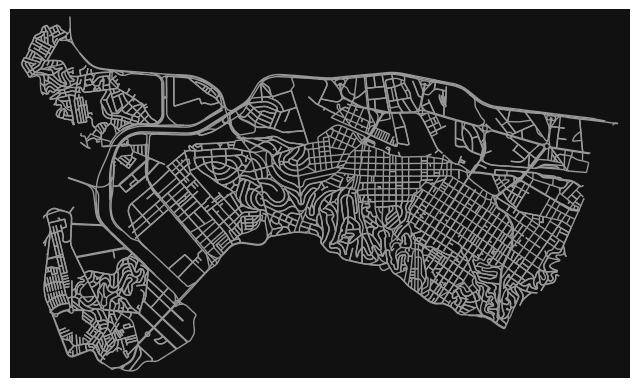

Verificação se os atributos do GDF foram transferidos para o grafo:
osmid
highway
lanes
maxspeed
name
oneway
ref
reversed
length
geometry
speed_kph
pct20.0_h_4374000
pct20.0_h_4377600
pct20.0_h_4381200
pct20.0_h_4384800
pct20.0_h_4388400
pct20.0_h_4392000
pct20.0_h_4395600
pct20.0_h_4399200
pct20.0_h_4402800
pct20.0_h_4406400
pct20.0_h_4410000
tt_pct20.0_h_4374000
tt_pct20.0_h_4377600
tt_pct20.0_h_4381200
tt_pct20.0_h_4384800
tt_pct20.0_h_4388400
tt_pct20.0_h_4392000
tt_pct20.0_h_4395600
tt_pct20.0_h_4399200
tt_pct20.0_h_4402800
tt_pct20.0_h_4406400
tt_pct20.0_h_4410000
tt_speed_kph

4. Grafo de viagem reconstruido ✅

📦 Atributos encontrados:
tt_pct20.0_h_4392000
tt_pct20.0_h_4410000
tt_pct20.0_h_4377600
tt_pct20.0_h_4402800
tt_pct20.0_h_4395600
tt_pct20.0_h_4388400
tt_pct20.0_h_4374000
tt_pct20.0_h_4384800
tt_pct20.0_h_4381200
tt_pct20.0_h_4399200
tt_pct20.0_h_4406400

5. Atributos de tempo de viagem listados ✅


🌧️ FASE 1: Calculando cenários COM CHUVA...



Calculando tempo de viagem COM CHUVA para: tt_pct20.0_h_4392000


Tempo de processamento: 15.58 s
Viagens calculadas: 307
🔍 125 rotas intransitáveis.

Calculando tempo de viagem COM CHUVA para: tt_pct20.0_h_4410000


Tempo de processamento: 18.26 s
Viagens calculadas: 307
🔍 150 rotas intransitáveis.

Calculando tempo de viagem COM CHUVA para: tt_pct20.0_h_4377600


Tempo de processamento: 2.41 s
Viagens calculadas: 307
🔍 27 rotas intransitáveis.

Calculando tempo de viagem COM CHUVA para: tt_pct20.0_h_4402800


Tempo de processamento: 17.85 s
Viagens calculadas: 307
🔍 150 rotas intransitáveis.

Calculando tempo de viagem COM CHUVA para: tt_pct20.0_h_4395600


Tempo de processamento: 14.77 s
Viagens calculadas: 307
🔍 126 rotas intransitáveis.

Calculando tempo de viagem COM CHUVA para: tt_pct20.0_h_4388400


Tempo de processamento: 15.20 s
Viagens calculadas: 307
🔍 119 rotas intransitáveis.

Calculando tempo de viagem COM CHUVA para: tt_pct20.0_h_4374000


Tempo de processamento: 1.67 s
Viagens calculadas: 307
🔍 0 rotas intransitáveis.

Calculando tempo de viagem COM CHUVA para: tt_pct20.0_h_4384800


Tempo de processamento: 13.79 s
Viagens calculadas: 307
🔍 106 rotas intransitáveis.

Calculando tempo de viagem COM CHUVA para: tt_pct20.0_h_4381200


Tempo de processamento: 4.04 s
Viagens calculadas: 307
🔍 35 rotas intransitáveis.

Calculando tempo de viagem COM CHUVA para: tt_pct20.0_h_4399200


Tempo de processamento: 17.28 s
Viagens calculadas: 307
🔍 138 rotas intransitáveis.

Calculando tempo de viagem COM CHUVA para: tt_pct20.0_h_4406400


Cenário com chuva: 100%|██████████| 11/11 [02:18<00:00, 12.60s/atributo]


Tempo de processamento: 17.57 s
Viagens calculadas: 307
🔍 150 rotas intransitáveis.

🏆 Pior momento: tt_pct20.0_h_4410000 com 150 rotas intransitáveis.

🔁 FASE 2: Recalculando todos os momentos COM e SEM chuva (usando os pares ignorados do pior momento)...



Recalculando COM CHUVA para tt_pct20.0_h_4392000
Tempo de processamento: 1.01 s
Viagens calculadas: 157

Calculando SEM CHUVA (modificado) para tt_pct20.0_h_4392000


Tempo de processamento: 0.77 s
Viagens calculadas: 157

Recalculando COM CHUVA para tt_pct20.0_h_4410000
Tempo de processamento: 1.01 s
Viagens calculadas: 157

Calculando SEM CHUVA (modificado) para tt_pct20.0_h_4410000


Tempo de processamento: 0.78 s
Viagens calculadas: 157

Recalculando COM CHUVA para tt_pct20.0_h_4377600
Tempo de processamento: 0.99 s
Viagens calculadas: 157

Calculando SEM CHUVA (modificado) para tt_pct20.0_h_4377600


Tempo de processamento: 0.78 s
Viagens calculadas: 157

Recalculando COM CHUVA para tt_pct20.0_h_4402800
Tempo de processamento: 0.95 s
Viagens calculadas: 157

Calculando SEM CHUVA (modificado) para tt_pct20.0_h_4402800


Tempo de processamento: 0.77 s
Viagens calculadas: 157

Recalculando COM CHUVA para tt_pct20.0_h_4395600
Tempo de processamento: 0.95 s
Viagens calculadas: 157

Calculando SEM CHUVA (modificado) para tt_pct20.0_h_4395600


Tempo de processamento: 0.89 s
Viagens calculadas: 157

Recalculando COM CHUVA para tt_pct20.0_h_4388400
Tempo de processamento: 0.99 s
Viagens calculadas: 157

Calculando SEM CHUVA (modificado) para tt_pct20.0_h_4388400


Tempo de processamento: 0.78 s
Viagens calculadas: 157

Recalculando COM CHUVA para tt_pct20.0_h_4374000
Tempo de processamento: 0.80 s
Viagens calculadas: 157

Calculando SEM CHUVA (modificado) para tt_pct20.0_h_4374000


Tempo de processamento: 0.79 s
Viagens calculadas: 157

Recalculando COM CHUVA para tt_pct20.0_h_4384800
Tempo de processamento: 1.03 s
Viagens calculadas: 157

Calculando SEM CHUVA (modificado) para tt_pct20.0_h_4384800


Tempo de processamento: 0.92 s
Viagens calculadas: 157

Recalculando COM CHUVA para tt_pct20.0_h_4381200
Tempo de processamento: 1.00 s
Viagens calculadas: 157

Calculando SEM CHUVA (modificado) para tt_pct20.0_h_4381200


Tempo de processamento: 0.78 s
Viagens calculadas: 157

Recalculando COM CHUVA para tt_pct20.0_h_4399200
Tempo de processamento: 0.95 s
Viagens calculadas: 157

Calculando SEM CHUVA (modificado) para tt_pct20.0_h_4399200


Tempo de processamento: 0.78 s
Viagens calculadas: 157

Recalculando COM CHUVA para tt_pct20.0_h_4406400
Tempo de processamento: 0.96 s
Viagens calculadas: 157

Calculando SEM CHUVA (modificado) para tt_pct20.0_h_4406400


Reprocessando: 100%|██████████| 11/11 [00:19<00:00,  1.79s/atributo]
✔️ Concluído: Pacote_20 | LAPA
Processando pendências:  50%|█████     | 1/2 [02:43<02:43, 163.84s/it]
🔄 Iniciando: Pacote_21 | LAPA


Tempo de processamento: 0.79 s
Viagens calculadas: 157

6. Resultados de resiliência calculados ✅

🔄 Processando Pacote_21 | LAPA

Listagem dos arquivos a serem processados:
Pacote_21, LAPA, pct21.0_h_4402800_LAPA.tif
Pacote_21, LAPA, pct21.0_h_4406400_LAPA.tif
Pacote_21, LAPA, pct21.0_h_4410000_LAPA.tif
Pacote_21, LAPA, pct21.0_h_4413600_LAPA.tif
Pacote_21, LAPA, pct21.0_h_4417200_LAPA.tif
Pacote_21, LAPA, pct21.0_h_4420800_LAPA.tif
Pacote_21, LAPA, pct21.0_h_4424400_LAPA.tif
Pacote_21, LAPA, pct21.0_h_4428000_LAPA.tif
Pacote_21, LAPA, pct21.0_h_4431600_LAPA.tif
Pacote_21, LAPA, pct21.0_h_4435200_LAPA.tif
Pacote_21, LAPA, pct21.0_h_4438800_LAPA.tif
Pacote_21, LAPA, pct21.0_h_4442400_LAPA.tif
Pacote_21, LAPA, pct21.0_h_4446000_LAPA.tif
Pacote_21, LAPA, pct21.0_h_4449600_LAPA.tif
Pacote_21, LAPA, pct21.0_h_4453200_LAPA.tif
Pacote_21, LAPA, pct21.0_h_4456800_LAPA.tif
Pacote_21, LAPA, pct21.0_h_4460400_LAPA.tif
Pacote_21, LAPA, pct21.0_h_4464000_LAPA.tif
Pacote_21, LAPA, pct21.0_h_4467600

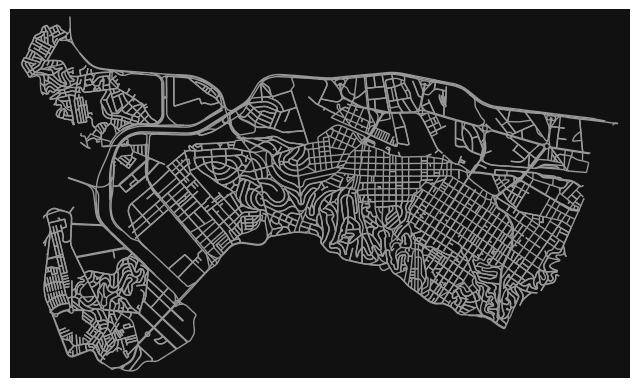

Verificação se os atributos do GDF foram transferidos para o grafo:
osmid
highway
lanes
maxspeed
name
oneway
ref
reversed
length
geometry
speed_kph
pct21.0_h_4402800
pct21.0_h_4406400
pct21.0_h_4410000
pct21.0_h_4413600
pct21.0_h_4417200
pct21.0_h_4420800
pct21.0_h_4424400
pct21.0_h_4428000
pct21.0_h_4431600
pct21.0_h_4435200
pct21.0_h_4438800
pct21.0_h_4442400
pct21.0_h_4446000
pct21.0_h_4449600
pct21.0_h_4453200
pct21.0_h_4456800
pct21.0_h_4460400
pct21.0_h_4464000
pct21.0_h_4467600
pct21.0_h_4471200
pct21.0_h_4474800
pct21.0_h_4478400
pct21.0_h_4482000
pct21.0_h_4485600
pct21.0_h_4489200
pct21.0_h_4492800
pct21.0_h_4496400
tt_pct21.0_h_4402800
tt_pct21.0_h_4406400
tt_pct21.0_h_4410000
tt_pct21.0_h_4413600
tt_pct21.0_h_4417200
tt_pct21.0_h_4420800
tt_pct21.0_h_4424400
tt_pct21.0_h_4428000
tt_pct21.0_h_4431600
tt_pct21.0_h_4435200
tt_pct21.0_h_4438800
tt_pct21.0_h_4442400
tt_pct21.0_h_4446000
tt_pct21.0_h_4449600
tt_pct21.0_h_4453200
tt_pct21.0_h_4456800
tt_pct21.0_h_4460400
tt_pct21.


Calculando tempo de viagem COM CHUVA para: tt_pct21.0_h_4489200


Tempo de processamento: 18.18 s
Viagens calculadas: 307
🔍 150 rotas intransitáveis.

Calculando tempo de viagem COM CHUVA para: tt_pct21.0_h_4456800


Tempo de processamento: 17.73 s
Viagens calculadas: 307
🔍 150 rotas intransitáveis.

Calculando tempo de viagem COM CHUVA para: tt_pct21.0_h_4496400


Tempo de processamento: 18.22 s
Viagens calculadas: 307
🔍 150 rotas intransitáveis.

Calculando tempo de viagem COM CHUVA para: tt_pct21.0_h_4420800


Tempo de processamento: 14.12 s
Viagens calculadas: 307
🔍 119 rotas intransitáveis.

Calculando tempo de viagem COM CHUVA para: tt_pct21.0_h_4482000


Tempo de processamento: 18.16 s
Viagens calculadas: 307
🔍 150 rotas intransitáveis.

Calculando tempo de viagem COM CHUVA para: tt_pct21.0_h_4471200


Tempo de processamento: 18.80 s
Viagens calculadas: 307
🔍 150 rotas intransitáveis.

Calculando tempo de viagem COM CHUVA para: tt_pct21.0_h_4406400


Tempo de processamento: 2.12 s
Viagens calculadas: 307
🔍 27 rotas intransitáveis.

Calculando tempo de viagem COM CHUVA para: tt_pct21.0_h_4438800


Tempo de processamento: 16.72 s
Viagens calculadas: 307
🔍 138 rotas intransitáveis.

Calculando tempo de viagem COM CHUVA para: tt_pct21.0_h_4474800


Tempo de processamento: 18.12 s
Viagens calculadas: 307
🔍 150 rotas intransitáveis.

Calculando tempo de viagem COM CHUVA para: tt_pct21.0_h_4435200


Tempo de processamento: 14.34 s
Viagens calculadas: 307
🔍 126 rotas intransitáveis.

Calculando tempo de viagem COM CHUVA para: tt_pct21.0_h_4453200


Tempo de processamento: 17.21 s
Viagens calculadas: 307
🔍 150 rotas intransitáveis.

Calculando tempo de viagem COM CHUVA para: tt_pct21.0_h_4485600


Tempo de processamento: 18.46 s
Viagens calculadas: 307
🔍 150 rotas intransitáveis.

Calculando tempo de viagem COM CHUVA para: tt_pct21.0_h_4428000


Tempo de processamento: 14.58 s
Viagens calculadas: 307
🔍 125 rotas intransitáveis.

Calculando tempo de viagem COM CHUVA para: tt_pct21.0_h_4410000


Tempo de processamento: 4.04 s
Viagens calculadas: 307
🔍 35 rotas intransitáveis.

Calculando tempo de viagem COM CHUVA para: tt_pct21.0_h_4449600


Tempo de processamento: 17.20 s
Viagens calculadas: 307
🔍 150 rotas intransitáveis.

Calculando tempo de viagem COM CHUVA para: tt_pct21.0_h_4431600


Tempo de processamento: 14.39 s
Viagens calculadas: 307
🔍 126 rotas intransitáveis.

Calculando tempo de viagem COM CHUVA para: tt_pct21.0_h_4417200


Tempo de processamento: 13.11 s
Viagens calculadas: 307
🔍 107 rotas intransitáveis.

Calculando tempo de viagem COM CHUVA para: tt_pct21.0_h_4467600


Tempo de processamento: 18.22 s
Viagens calculadas: 307
🔍 150 rotas intransitáveis.

Calculando tempo de viagem COM CHUVA para: tt_pct21.0_h_4464000


Tempo de processamento: 18.10 s
Viagens calculadas: 307
🔍 150 rotas intransitáveis.

Calculando tempo de viagem COM CHUVA para: tt_pct21.0_h_4413600


Tempo de processamento: 4.01 s
Viagens calculadas: 307
🔍 35 rotas intransitáveis.

Calculando tempo de viagem COM CHUVA para: tt_pct21.0_h_4402800


Tempo de processamento: 1.74 s
Viagens calculadas: 307
🔍 0 rotas intransitáveis.

Calculando tempo de viagem COM CHUVA para: tt_pct21.0_h_4424400


Tempo de processamento: 14.48 s
Viagens calculadas: 307
🔍 125 rotas intransitáveis.

Calculando tempo de viagem COM CHUVA para: tt_pct21.0_h_4460400


Tempo de processamento: 19.01 s
Viagens calculadas: 307
🔍 150 rotas intransitáveis.

Calculando tempo de viagem COM CHUVA para: tt_pct21.0_h_4492800


Tempo de processamento: 18.46 s
Viagens calculadas: 307
🔍 150 rotas intransitáveis.

Calculando tempo de viagem COM CHUVA para: tt_pct21.0_h_4442400


Tempo de processamento: 17.70 s
Viagens calculadas: 307
🔍 150 rotas intransitáveis.

Calculando tempo de viagem COM CHUVA para: tt_pct21.0_h_4446000


Tempo de processamento: 17.07 s
Viagens calculadas: 307
🔍 150 rotas intransitáveis.

Calculando tempo de viagem COM CHUVA para: tt_pct21.0_h_4478400


Cenário com chuva: 100%|██████████| 27/27 [06:42<00:00, 14.91s/atributo]


Tempo de processamento: 17.85 s
Viagens calculadas: 307
🔍 150 rotas intransitáveis.

🏆 Pior momento: tt_pct21.0_h_4489200 com 150 rotas intransitáveis.

🔁 FASE 2: Recalculando todos os momentos COM e SEM chuva (usando os pares ignorados do pior momento)...



Recalculando COM CHUVA para tt_pct21.0_h_4489200
Tempo de processamento: 1.02 s
Viagens calculadas: 157

Calculando SEM CHUVA (modificado) para tt_pct21.0_h_4489200


Tempo de processamento: 0.78 s
Viagens calculadas: 157

Recalculando COM CHUVA para tt_pct21.0_h_4456800
Tempo de processamento: 1.09 s
Viagens calculadas: 157

Calculando SEM CHUVA (modificado) para tt_pct21.0_h_4456800


Tempo de processamento: 0.81 s
Viagens calculadas: 157

Recalculando COM CHUVA para tt_pct21.0_h_4496400
Tempo de processamento: 0.97 s
Viagens calculadas: 157

Calculando SEM CHUVA (modificado) para tt_pct21.0_h_4496400


Tempo de processamento: 0.78 s
Viagens calculadas: 157

Recalculando COM CHUVA para tt_pct21.0_h_4420800
Tempo de processamento: 0.95 s
Viagens calculadas: 157

Calculando SEM CHUVA (modificado) para tt_pct21.0_h_4420800


Tempo de processamento: 0.78 s
Viagens calculadas: 157

Recalculando COM CHUVA para tt_pct21.0_h_4482000
Tempo de processamento: 1.03 s
Viagens calculadas: 157

Calculando SEM CHUVA (modificado) para tt_pct21.0_h_4482000


Tempo de processamento: 0.78 s
Viagens calculadas: 157

Recalculando COM CHUVA para tt_pct21.0_h_4471200
Tempo de processamento: 1.02 s
Viagens calculadas: 157

Calculando SEM CHUVA (modificado) para tt_pct21.0_h_4471200


Tempo de processamento: 0.79 s
Viagens calculadas: 157

Recalculando COM CHUVA para tt_pct21.0_h_4406400
Tempo de processamento: 0.90 s
Viagens calculadas: 157

Calculando SEM CHUVA (modificado) para tt_pct21.0_h_4406400


Tempo de processamento: 0.78 s
Viagens calculadas: 157

Recalculando COM CHUVA para tt_pct21.0_h_4438800
Tempo de processamento: 1.01 s
Viagens calculadas: 157

Calculando SEM CHUVA (modificado) para tt_pct21.0_h_4438800


Tempo de processamento: 0.78 s
Viagens calculadas: 157

Recalculando COM CHUVA para tt_pct21.0_h_4474800
Tempo de processamento: 1.01 s
Viagens calculadas: 157

Calculando SEM CHUVA (modificado) para tt_pct21.0_h_4474800


Tempo de processamento: 0.77 s
Viagens calculadas: 157

Recalculando COM CHUVA para tt_pct21.0_h_4435200
Tempo de processamento: 0.94 s
Viagens calculadas: 157

Calculando SEM CHUVA (modificado) para tt_pct21.0_h_4435200


Tempo de processamento: 0.77 s
Viagens calculadas: 157

Recalculando COM CHUVA para tt_pct21.0_h_4453200
Tempo de processamento: 1.02 s
Viagens calculadas: 157

Calculando SEM CHUVA (modificado) para tt_pct21.0_h_4453200


Tempo de processamento: 0.78 s
Viagens calculadas: 157

Recalculando COM CHUVA para tt_pct21.0_h_4485600
Tempo de processamento: 1.11 s
Viagens calculadas: 157

Calculando SEM CHUVA (modificado) para tt_pct21.0_h_4485600


Tempo de processamento: 0.79 s
Viagens calculadas: 157

Recalculando COM CHUVA para tt_pct21.0_h_4428000
Tempo de processamento: 1.04 s
Viagens calculadas: 157

Calculando SEM CHUVA (modificado) para tt_pct21.0_h_4428000


Tempo de processamento: 0.79 s
Viagens calculadas: 157

Recalculando COM CHUVA para tt_pct21.0_h_4410000
Tempo de processamento: 0.95 s
Viagens calculadas: 157

Calculando SEM CHUVA (modificado) para tt_pct21.0_h_4410000


Tempo de processamento: 0.78 s
Viagens calculadas: 157

Recalculando COM CHUVA para tt_pct21.0_h_4449600
Tempo de processamento: 1.04 s
Viagens calculadas: 157

Calculando SEM CHUVA (modificado) para tt_pct21.0_h_4449600


Tempo de processamento: 0.81 s
Viagens calculadas: 157

Recalculando COM CHUVA para tt_pct21.0_h_4431600
Tempo de processamento: 1.02 s
Viagens calculadas: 157

Calculando SEM CHUVA (modificado) para tt_pct21.0_h_4431600


Tempo de processamento: 0.78 s
Viagens calculadas: 157

Recalculando COM CHUVA para tt_pct21.0_h_4417200
Tempo de processamento: 0.94 s
Viagens calculadas: 157

Calculando SEM CHUVA (modificado) para tt_pct21.0_h_4417200


Tempo de processamento: 0.77 s
Viagens calculadas: 157

Recalculando COM CHUVA para tt_pct21.0_h_4467600
Tempo de processamento: 1.02 s
Viagens calculadas: 157

Calculando SEM CHUVA (modificado) para tt_pct21.0_h_4467600


Tempo de processamento: 0.78 s
Viagens calculadas: 157

Recalculando COM CHUVA para tt_pct21.0_h_4464000
Tempo de processamento: 0.96 s
Viagens calculadas: 157

Calculando SEM CHUVA (modificado) para tt_pct21.0_h_4464000


Tempo de processamento: 0.81 s
Viagens calculadas: 157

Recalculando COM CHUVA para tt_pct21.0_h_4413600
Tempo de processamento: 1.06 s
Viagens calculadas: 157

Calculando SEM CHUVA (modificado) para tt_pct21.0_h_4413600


Tempo de processamento: 0.81 s
Viagens calculadas: 157

Recalculando COM CHUVA para tt_pct21.0_h_4402800
Tempo de processamento: 0.87 s
Viagens calculadas: 157

Calculando SEM CHUVA (modificado) para tt_pct21.0_h_4402800


Tempo de processamento: 0.81 s
Viagens calculadas: 157

Recalculando COM CHUVA para tt_pct21.0_h_4424400
Tempo de processamento: 0.96 s
Viagens calculadas: 157

Calculando SEM CHUVA (modificado) para tt_pct21.0_h_4424400


Tempo de processamento: 0.79 s
Viagens calculadas: 157

Recalculando COM CHUVA para tt_pct21.0_h_4460400
Tempo de processamento: 1.04 s
Viagens calculadas: 157

Calculando SEM CHUVA (modificado) para tt_pct21.0_h_4460400


Tempo de processamento: 0.94 s
Viagens calculadas: 157

Recalculando COM CHUVA para tt_pct21.0_h_4492800
Tempo de processamento: 1.03 s
Viagens calculadas: 157

Calculando SEM CHUVA (modificado) para tt_pct21.0_h_4492800


Tempo de processamento: 0.81 s
Viagens calculadas: 157

Recalculando COM CHUVA para tt_pct21.0_h_4442400
Tempo de processamento: 0.99 s
Viagens calculadas: 157

Calculando SEM CHUVA (modificado) para tt_pct21.0_h_4442400


Tempo de processamento: 0.81 s
Viagens calculadas: 157

Recalculando COM CHUVA para tt_pct21.0_h_4446000
Tempo de processamento: 0.98 s
Viagens calculadas: 157

Calculando SEM CHUVA (modificado) para tt_pct21.0_h_4446000


Tempo de processamento: 0.81 s
Viagens calculadas: 157

Recalculando COM CHUVA para tt_pct21.0_h_4478400
Tempo de processamento: 1.14 s
Viagens calculadas: 157

Calculando SEM CHUVA (modificado) para tt_pct21.0_h_4478400


Reprocessando: 100%|██████████| 27/27 [00:49<00:00,  1.82s/atributo]

Tempo de processamento: 0.80 s
Viagens calculadas: 157

6. Resultados de resiliência calculados ✅




✔️ Concluído: Pacote_21 | LAPA
Processando pendências: 100%|██████████| 2/2 [10:25<00:00, 312.83s/it]
✅ Processamento finalizado e status atualizado.


✅ Resultado salvo na variável: df_result_resiliencia_LAPA_Pacote_20_Pacote_21


In [ ]:
pacote_inicio = 'Pacote_01'
pacote_fim = 'Pacote_66'

df_resultados_resiliencia = processar_pendencias(
                                diretorio_raiz=diretorio_raiz,
                                pacote_inicio=pacote_inicio,
                                pacote_fim=pacote_fim,
                                edges_baseline_reprojected=edges_baseline_reprojected,
                                node_baseline=node_baseline,
                                subprefeitura=nome_sp,
                                threshold=70,
                                threshold_max=300,
                                status_filename='status_pacotes.csv',
                                verbose=True
                                )

# Só continua se o DataFrame for válido
if df_resultados_resiliencia is not None and not df_resultados_resiliencia.empty:
    nome_variavel = f"df_result_resiliencia_{nome_sp}_{pacote_inicio}_{pacote_fim}"
    
    # Salva como variável dinâmica
    globals()[nome_variavel] = df_resultados_resiliencia.copy()

    #Gera o nome do arquivo
    nome_arquivo = f"{nome_variavel}.csv"
    
    # Salva em disco
    df_resultados_resiliencia.to_csv(nome_arquivo, index=False)
    
    print(f"✅ Resultado salvo na variável: {nome_variavel}")
    print(f"📁 Arquivo CSV salvo como: {nome_arquivo}")
else:
    print("⚠️ Nenhum resultado gerado por processar_pendencias.")

In [181]:
df_resultados_resiliencia

,Pacote,Subprefeitura,coluna,tt_chuva,tt_seco_mod,Pares OD excluidos,tempo_execucao_chuva,tempo_execucao_mod,Subprefeitura
0,Pacote_20,LAPA,tt_pct20.0_h_4392000,5.654715,4.399798,150,1.018884,0.781497,LAPA
1,Pacote_20,LAPA,tt_pct20.0_h_4410000,5.562764,4.399798,150,1.020116,0.790479,LAPA
2,Pacote_20,LAPA,tt_pct20.0_h_4377600,5.514344,4.399798,150,0.996478,0.783075,LAPA
3,Pacote_20,LAPA,tt_pct20.0_h_4402800,5.351785,4.399798,150,0.956754,0.778698,LAPA
4,Pacote_20,LAPA,tt_pct20.0_h_4395600,5.478810,4.399798,150,0.953257,0.894446,LAPA
5,Pacote_20,LAPA,tt_pct20.0_h_4388400,5.788070,4.399798,150,1.000036,0.784535,LAPA
6,Pacote_20,LAPA,tt_pct20.0_h_4374000,4.399798,4.399798,150,0.810701,0.794166,LAPA
7,Pacote_20,LAPA,tt_pct20.0_h_4384800,5.767062,4.399798,150,1.034688,0.929201,LAPA
8,Pacote_20,LAPA,tt_pct20.0_h_4381200,5.638356,4.399798,150,1.005029,0.785338,LAPA
9,Pacote_20,LAPA,tt_pct20.0_h_4399200,5.390677,4.399798,150,0.956337,0.785596,LAPA
